# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some output activations to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [4]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [16]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [17]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:
[When we do not divide by p during the training step, we scale the activations by p during the prediction time. We do this, because we want the outputs of neurons at test time to be identical to their expected outputs at training time. So we compute the expected output which will be: E(x) = px + (1-p)*x = p*x. This step can be done at training time, making us win some time at test time.]


# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specifically, if the constructor of the network receives a value that is not 1 for the `dropout` parameter, then the net should add a dropout layer immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [36]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout=1 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 4.76e-06
W3 relative error: 2.60e-08
b1 relative error: 4.73e-09
b2 relative error: 1.82e-09
b3 relative error: 1.70e-10

Running check with dropout =  0.5
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Initial loss:  2.3042759220785896
W1 relative error: 3.11e-07
W2 relative error: 1.84e-08
W3 relative error: 5.35e-08
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 1.13e-10



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [41]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0.25,0.5,0.75,1]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver
  print()

dict_keys(['W1', 'b1', 'W2', 'b2'])
0.25
(Iteration 1 / 125) loss: 17.167133
(Epoch 0 / 25) train acc: 0.232000; val_acc: 0.183000
(Epoch 1 / 25) train acc: 0.348000; val_acc: 0.223000
(Epoch 2 / 25) train acc: 0.438000; val_acc: 0.279000
(Epoch 3 / 25) train acc: 0.484000; val_acc: 0.294000
(Epoch 4 / 25) train acc: 0.566000; val_acc: 0.305000
(Epoch 5 / 25) train acc: 0.620000; val_acc: 0.331000
(Epoch 6 / 25) train acc: 0.634000; val_acc: 0.327000
(Epoch 7 / 25) train acc: 0.670000; val_acc: 0.330000
(Epoch 8 / 25) train acc: 0.686000; val_acc: 0.302000
(Epoch 9 / 25) train acc: 0.744000; val_acc: 0.319000
(Epoch 10 / 25) train acc: 0.720000; val_acc: 0.296000
(Epoch 11 / 25) train acc: 0.774000; val_acc: 0.294000
(Epoch 12 / 25) train acc: 0.820000; val_acc: 0.293000
(Epoch 13 / 25) train acc: 0.798000; val_acc: 0.323000
(Epoch 14 / 25) train acc: 0.832000; val_acc: 0.325000
(Epoch 15 / 25) train acc: 0.812000; val_acc: 0.308000
(Epoch 16 / 25) train acc: 0.854000; val_acc: 0.31800

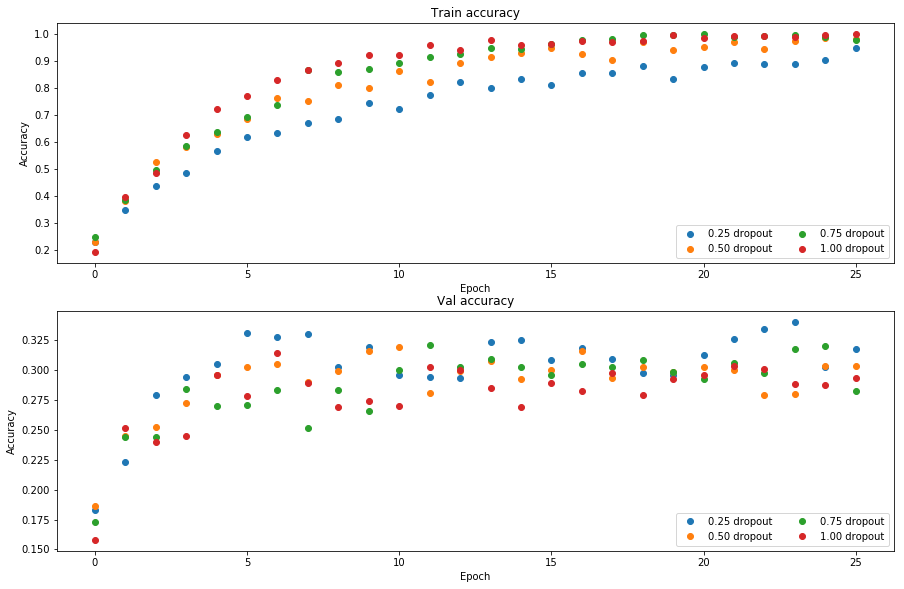

In [42]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:
[The validation accuracy with dropout is better because of the regularization effect dropout has on the training, thus limiting overfitting and making the modal more generalizable to validation/testing data
The more dropout we have, the more validation accuracy there is.
The dropout makes it also longer to overfit the training data]


## Inline Question 3:
Suppose we are training a deep fully-connected network for image classification, with dropout after hidden layers (parameterized by keep probability p). If we are concerned about overfitting, how should we modify p (if at all) when we decide to decrease the size of the hidden layers (that is, the number of nodes in each layer)?

## Answer:
[If we decrease the number of hidden layers we should also decrease the dropout effect to keep more neurons, we should then increase p in our case (the probability to keep a neuron). Otherwise, the network wouldn't learn much.]
